# Notebook showing construction of transect plots


I used the cosima cookbook in my analysis to extract data from the ACCESS-OM2-01 model.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy as scipy

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs

from scipy import stats
import cosima_cookbook as cc
import gsw
#plt.rcParams['text.usetex'] = False
from xhistogram.xarray import histogram
import cmocean


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/ryf9091.db')

Loading the variables

In [4]:
expt = '01deg_jra55v13_ryf9091'
variable = 'salt'
darray = cc.querying.getvar(expt,variable, session,ncfile='ocean.nc', start_time='2059-01-01', end_time='2059-12-31', chunks={'st_ocean':None}).sel(time = slice('2059-01-01','2059-12-31'))
variable1 = 'temp'
darray1 = cc.querying.getvar(expt,variable1, session,ncfile='ocean.nc', start_time='2059-01-01', end_time='2059-12-31', chunks={'st_ocean':None}).sel(time = slice('2059-01-01','2059-12-31'))
variable2 = 'pot_rho_2'
darray2 = cc.querying.getvar(expt,variable2, session,ncfile='ocean.nc', start_time='2059-01-01', end_time='2059-12-31', chunks={'st_ocean':None}).sel(time = slice('2059-01-01','2059-12-31'))
variable3 = 'age_global'
darray3 = cc.querying.getvar(expt,variable3, session,ncfile='ocean.nc', start_time='2059-01-01', end_time='2059-12-31', chunks={'st_ocean':None}).sel(time = slice('2059-01-01','2059-12-31'))
variable4= 'dzt'
darray4 = cc.querying.getvar(expt,variable4, session,ncfile='ocean.nc', start_time='2059-01-01', end_time='2059-12-31', chunks={'st_ocean':None}).sel(time = slice('2059-01-01','2059-12-31'))
variable5= 'area_t'
darray5 = cc.querying.getvar(expt,variable5, session,n=1)
variable6= 'ht'
darray6 = cc.querying.getvar(expt,variable6, session,n=1)
variable7= 'dxt'
darray7 = cc.querying.getvar(expt,variable7, session,n=-1, ncfile = 'ocean_grid.nc')# ncfile = 'output675/ice/OUTPUT/iceh.2069-12.nc', start_time='2059-01-01', end_time='2059-12-31').sel(time = slice('2059-01-01','2059-12-31'))
variable8= 'dyt'
darray8 = cc.querying.getvar(expt,variable8, session,n=-1, ncfile = 'ocean_grid.nc')# ncfile = 'iceh.2069-12.nc', start_time='2059-01-01', end_time='2059-12-31').sel(time = slice('2059-01-01','2059-12-31'))
combined_array = xr.merge([darray, darray1, darray2, darray3, darray4, darray5, darray6, darray7, darray8])

#combined_array = xr.merge([darray, darray1, darray2, darray3, darray4, darray5])
combined_array

<xarray.Dataset>
Dimensions:     (st_ocean: 75, time: 12, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * st_ocean    (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yt_ocean    (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * xt_ocean    (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * time        (time) object 2059-01-16 12:00:00 ... 2059-12-16 12:00:00
    geolon_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
Data variables:
    salt        (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 2700, 3600), meta=np.ndarray>
    temp        (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 2700, 3600), meta=np.ndarray>
    pot_rho_2   (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 2700, 3600), meta=np.ndarray>
    age_global  (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 2700, 3600), meta=np.ndarray>
    dzt         (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 2700, 3600), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    ht          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>

Loading the variables for the Ross Sea region and defining some useful variables.

In [5]:
section = combined_array.sel(xt_ocean=slice(-200,-175)).sel(yt_ocean=slice(-78,-67))#.load()#.sel(st_ocean =slice(200,6000))


#ORSI AND WIDERWOHL 
#section = combined_array.sel(xt_ocean=slice(-204,-153)).sel(yt_ocean=slice(-79,-70))

#section = combined_array.sel(xt_ocean=slice(74,78)).sel(yt_ocean=slice(-70,-65))
section = section.assign(volume = lambda section : section.dzt * section.area_t)
section = section.assign(x = lambda section : section.salt*0+section.xt_ocean)
section = section.assign(y = lambda section : section.salt*0+section.yt_ocean)
section = section.assign(z = lambda section : section.salt*0+section.st_ocean)
section = section.assign(ht1 = lambda section : section.dzt*section.ht/section.dzt)
section = section.assign(temp1 = lambda section : section.temp - 273.15)

#section = section.assign(ht1 = lambda section : section.ht1/section.dzt)

section



<xarray.Dataset>
Dimensions:     (st_ocean: 75, time: 12, xt_ocean: 250, yt_ocean: 261)
Coordinates:
  * st_ocean    (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yt_ocean    (yt_ocean) float64 -77.98 -77.94 -77.9 ... -67.09 -67.04 -67.0
  * xt_ocean    (xt_ocean) float64 -199.9 -199.8 -199.7 ... -175.2 -175.1 -175.0
  * time        (time) object 2059-01-16 12:00:00 ... 2059-12-16 12:00:00
    geolon_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(261, 100), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(261, 100), meta=np.ndarray>
Data variables:
    salt        (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 250), meta=np.ndarray>
    temp        (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 250), meta=np.ndarray>
    pot_rho_2   (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 250), meta=np.ndarray>
    age_global  (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 250), meta=np.ndarray>
    dzt         (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 250), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(261, 100), meta=np.ndarray>
    ht          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(261, 100), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(261, 100), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(261, 100), meta=np.ndarray>
    volume      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>
    x           (time, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 75, 261, 250), meta=np.ndarray>
    y           (time, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 75, 261, 250), meta=np.ndarray>
    z           (time, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 75, 261, 250), meta=np.ndarray>
    ht1         (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>
    temp1       (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 250), meta=np.ndarray>

I want to plot the transects with units of km instead of degrees, which is the default. Here is the dxt (meridional cell size) as a function of latitude for my section and the globe. It looks pretty straight in the Ross sea despite the curve on the globe so I assume a linear relationship between cell size and latitude when I calculate distances in the future. dyt, the zonal cell size, doesn't change with latitude nor longitude so I can assume that's a constant.

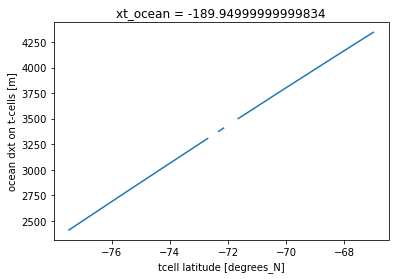

In [6]:
section.dxt.isel(xt_ocean = 100).plot()

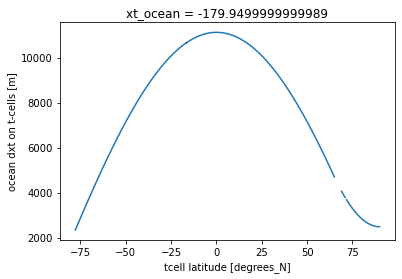

In [7]:
combined_array.dxt.isel(xt_ocean = 1000).plot()

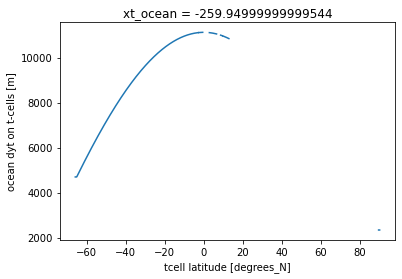

In [8]:
combined_array.dyt.isel(xt_ocean = 200).plot()

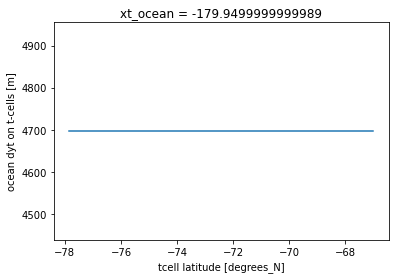

In [11]:
section.dyt.isel(xt_ocean = 200).plot()

The map for my analyses. I had to use several masks to make the transects - as the properties on the shelf differ to the shelf and deeper ocean. I used a bottom age mask for the off shelf transects and a bathymetry mask for on the shelf. For the transition between regions there was a bit of fiddling involved.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true

<Figure size 432x288 with 0 Axes>

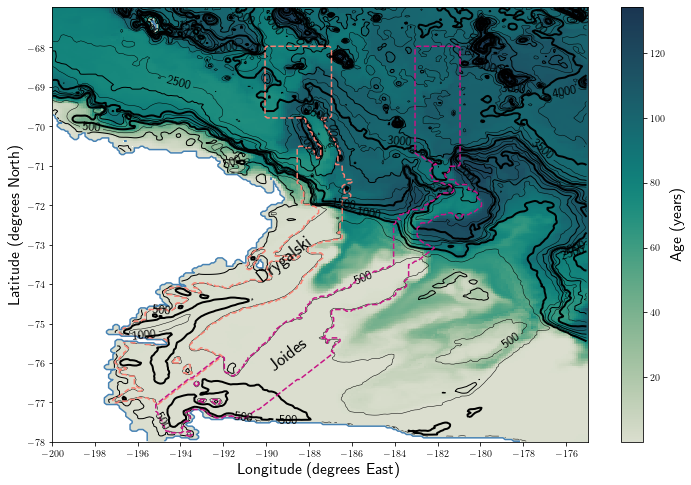

In [24]:
plt.rc('text', usetex=True)

fig = plt.figure()

cs = section.ht.plot.contour(figsize = (12,8), linewidths = (0.5,1,0.5,2,0.5,1,0.5,2,0.5,1,0.5,2,0.5,1,0.5,2,0.5,1,0.5,2,0.5,1,0.5,2), add_labels = True, levels = 20, cmap = 'Black', 
                             yticks = np.arange(-78,-67,1), xticks = np.arange(-200,-175,2))#, fmt = np.linspace(0,4250,250))
plt.clabel(cs,cs.levels[2::2], inline=True, fontsize=13, fmt='%i')#, np.linspace(0,4250,250))


cmap = cmocean.cm.tempo
newcmap = cmocean.tools.crop_by_percent(cmap, 20, which='both', N=None)
ds = section
ds = ds.isel(time = 0)
ds = ds.where(ds.z > ds.ht-100)
CS = ds.age_global.mean('st_ocean').plot(cmap = newcmap, add_colorbar = False)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('Age (years)', fontsize = 16)


ds = section
ds1 = ds.where(ds.z > ds.ht-100)
ds1 = ds1.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > -72).where(ds.y < -69.5).where(ds.x < -186 ).where(ds.x > -188.5)
ds = ds.where(ds1 < 95)
ds = ds.where(ds.ht > 800)
mask_ocean1 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land1 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

#DRYGALSKI SHELF
ds = section
ds = ds.where(ds.z > ds.ht-100)
ds1 = ds.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > 1+0.4*ds.x).where(ds.y < 4+0.4*ds.x).where(ds.y < -71).where(ds.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
#ds = ds.where(ds1<50)
ds = ds.where(np.sqrt((ds.x+190)**2+(ds.y+72)**2)>1)

ds = ds.where(ds.ht > 500)
mask_ocean2 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land2 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  


#DRYGALSKI CONNECTION
ds = section
ds = ds.where(ds.z > ds.ht-100)
ds1 = ds.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > 1+0.4*ds.x).where(ds.y < 4+0.4*ds.x).where(ds.y >-72.5).where(ds.y <-69).where(ds.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
ds = ds.where(ds1<50)
ds = ds.where(ds.ht > 450)
ds = ds.where(ds.x >-187.8)
#ds.age_global.isel(time=0).mean('st_ocean').plot()
mask_ocean3 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land3 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

#DRYGALSKI EXTENSION
ds = section
ds = ds.where(ds.y < -68).where(ds.y>-69.75).where(ds.x>-190).where(ds.x<-187)
#ds.age_global.isel(time=0).mean('st_ocean').plot()
mask_ocean4 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land4 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

mask_array = mask_ocean1 + mask_land1 +mask_ocean2 + mask_land2 +mask_ocean3 + mask_land3 #+mask_ocean4 + mask_land4
mask_array.plot.contour(colors = 'salmon', linestyles='dashed', levels = [2])

#COASTLINE
ds = section
mask_ocean = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  
mask_array = mask_ocean + mask_land
mask_array.plot.contour(colors = 'steelblue', levels = [2])

#JOIDES
ds = section
ds1 = ds.where(ds.z > ds.ht-100)
ds1 = ds1.age_global.isel(time = 0).mean('st_ocean')

ds2 = ds.where(ds.y > -1+0.4*ds.x).where(ds.y < 1+0.4*ds.x).where(ds.y < -72).where(ds.y < - 0.1*ds.x -91.5).where(ds.x < -183.4)#)#.where(ds.x < -188)# 

ds2 = ds2.where(ds.ht > 500)
mask_ocean2 = 2 * np.ones((ds2.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds2.salt.isel(time=0).mean('st_ocean'))  
mask_land2 = 1 * np.ones((ds2.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds2.salt.isel(time=0).mean('st_ocean'))  
mask_array2 = mask_ocean2 + mask_land2
ds3 = ds.where(ds.y > -73.5).where(ds.y < -69).where(ds.x < -180 ).where(ds.x > -184)

ds3 = ds3.where(ds1 < 90)
ds3 = ds3.where(ds.y > -0.2+0.4*ds.x)
mask_ocean3 = 2 * np.ones((ds3.dims['yt_ocean'], ds3.dims['xt_ocean'])) * np.isfinite(ds3.salt.isel(time=0).mean('st_ocean'))  
mask_land3 = 1 * np.ones((ds3.dims['yt_ocean'], ds3.dims['xt_ocean'])) * np.isnan(ds3.salt.isel(time=0).mean('st_ocean'))  
mask_array3 = mask_ocean3 + mask_land3
ds4 = section
ds4 = ds4.where(ds.y > -71).where(ds.y < -68).where(ds.x <-181).where(ds.x>-183).where(ds.y > - 0.27*ds.x -120.1)
mask_ocean4 = 2 * np.ones((ds4.dims['yt_ocean'], ds4.dims['xt_ocean'])) * np.isfinite(ds4.salt.isel(time=0).mean('st_ocean'))  
mask_land4 = 1 * np.ones((ds4.dims['yt_ocean'], ds4.dims['xt_ocean'])) * np.isnan(ds4.salt.isel(time=0).mean('st_ocean'))  
mask_array4 = mask_ocean4 + mask_land4
mask_array = mask_ocean2 + mask_land2 + mask_ocean3 + mask_land3 +mask_ocean4 + mask_land4
mask_array.plot.contour(colors = 'mediumvioletred', centre = 3, levels = [3], linestyles='dashed')

plt.title('')#Age of water in the bottom 100m of the ocean for the Ross Sea region', fontsize=16, fontweight='bold')
plt.ylabel('Latitude (degrees North)', fontsize = 16)
plt.xlabel('Longitude (degrees East)', fontsize = 16)
plt.text(0.38, 0.42, 'Drygalski', {'color': 'k', 'fontsize': 18},
         horizontalalignment='left',
         verticalalignment='center',
         rotation=38,
         clip_on=False,
         transform=plt.gca().transAxes)
plt.text(0.4, 0.2, 'Joides', {'color': 'k', 'fontsize': 18},
         horizontalalignment='left',
         verticalalignment='center',
         rotation=38,
         clip_on=False,
         transform=plt.gca().transAxes)
#plt.savefig('Nice_map_Ross_final2')

# Transects
Firstly, the slopy bit transects.
Defining the region:

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_ex

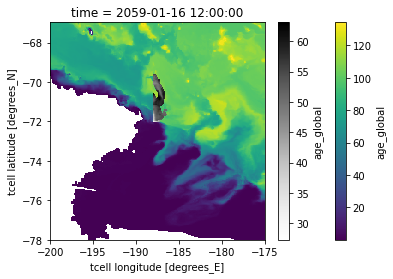

In [16]:
#making the mask
plt.rc('text', usetex=False)

ds = section
ds1 = ds.where(ds.z > ds.ht-100)
ds1 = ds1.age_global.isel(time = 0).mean('st_ocean')
ds1.plot()

ds = ds.where(ds.y > -72).where(ds.y < -69.5).where(ds.x < -186 ).where(ds.x > -188)
ds = ds.where(ds1 < 90)
#ds = ds.where(ds.ht > 800)
ds.age_global.isel(time = 0).mean('st_ocean').plot(cmap = 'Greys')#, size = 10,aspect = 1)

In [17]:
np.nanmean(combined_array.dxt.sel(xt_ocean = slice(-180.1,-179.9), yt_ocean = slice(-60.1,-59.9)).values)

5556.065

In [18]:
#defining a distance on the above mask
plt.rc('text', usetex=False)

ds = section#.isel(time = 0)
ds1 = ds.where(ds.z > ds.ht-100)
ds1 = ds1.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > -72).where(ds.y < -69.5).where(ds.x < -186 ).where(ds.x > -188)
ds = ds.where(ds1 < 90)
ds = ds.where(ds.ht > 700)
ds = ds.assign(distance = lambda ds :-ds.dzt*(np.sqrt(((ds.xt_ocean + 188)*10*(5556.065+ds.dxt)/2)**2+((ds.yt_ocean+60)*10*(5556.065+ds.dyt)/2)**2))/ds.dzt+615325)#.load()
ds

<xarray.Dataset>
Dimensions:     (st_ocean: 75, time: 12, xt_ocean: 250, yt_ocean: 261)
Coordinates:
  * st_ocean    (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yt_ocean    (yt_ocean) float64 -77.98 -77.94 -77.9 ... -67.09 -67.04 -67.0
  * xt_ocean    (xt_ocean) float64 -199.9 -199.8 -199.7 ... -175.2 -175.1 -175.0
  * time        (time) object 2059-01-16 12:00:00 ... 2059-12-16 12:00:00
    geolon_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(261, 100), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(261, 100), meta=np.ndarray>
Data variables:
    salt        (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>
    temp        (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>
    pot_rho_2   (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>
    age_global  (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>
    dzt         (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean, time, st_ocean) float32 dask.array<chunksize=(261, 100, 3, 75), meta=np.ndarray>
    ht          (yt_ocean, xt_ocean, time, st_ocean) float32 dask.array<chunksize=(261, 100, 3, 75), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean, time, st_ocean) float32 dask.array<chunksize=(261, 100, 3, 75), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean, time, st_ocean) float32 dask.array<chunksize=(261, 100, 3, 75), meta=np.ndarray>
    volume      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>
    x           (time, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>
    y           (time, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>
    z           (time, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>
    ht1         (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>
    distance    (time, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 75, 261, 100), meta=np.ndarray>

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


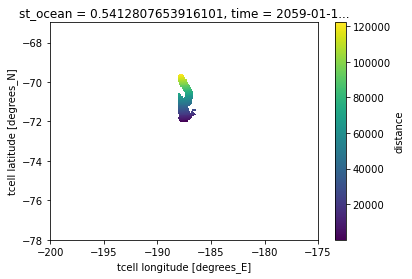

In [19]:
ds.distance.isel(st_ocean = 0, time = 0).plot()

In [20]:
print(np.nanmax(ds.distance.values))
print(np.nanmin(ds.distance.values))


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


122135.62459081557


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.22711188159883022


I want to find a relationship between distance and bathymetry so that I can scale the depth vs bathymetry histogram

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'histogram to show distance from (-200,-78) vs bathymetry')

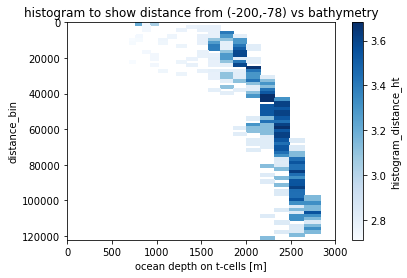

In [21]:
sbins = np.linspace(0,122136,70)
tbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
#hTS = histogram(ds.distance, ds.z, bins=[sbins, tbins])
#hTs.plot()

dVol = ds.volume.where(~np.isnan(ds.volume))
hDV = histogram(ds.distance.where(~np.isnan(ds.volume)), ds.ht.where(~np.isnan(ds.volume)), bins = [sbins, tbins])#, weights = dVol)
np.log10(hDV).plot(cmap = 'Blues', yincrease = False, xlim = (0,3000))
plt.title('histogram to show distance from (-200,-78) vs bathymetry')

want to use the weighted average by volume to find an average distance for each depth

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


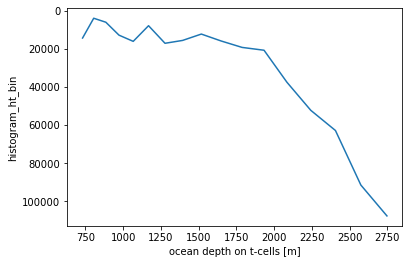

In [22]:
bins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
h = histogram(hDV.ht_bin, bins=[bins], weights = hDV.distance_bin*hDV)/histogram(hDV.ht_bin, bins=[bins], weights = hDV)
h.plot(yincrease = False)

Need to smoothen/make monotonically decreasing to avoid multivalued points, and since input of coordinates in an xarray needs to be monotonically increasing

Use a running average

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Text(0.5, 1.0, 'smoothed distance vs ht')

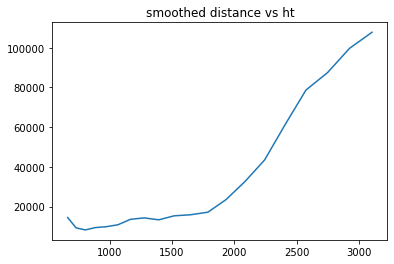

In [23]:
p = h.values

j = np.zeros(p.size)
j[0] = p[0]
j[-1]=p[-1]
for i in np.arange(1, p.size - 1, 1):

    j[i]= np.nanmean(p[i-2:i+2])
    print(i)

plt.plot(h.ht_bin_bin, j)
plt.title('smoothed distance vs ht')

In [24]:
j

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  14433.01672241,   9239.46488294,   8205.39949193,
         9384.4583146 ,   9821.22679168,  10801.0963569 ,  13565.08043742,
        14257.2899393 ,  13300.2527185 ,  15306.35126923,  15847.32283096,
        17135.58855532,  

Now we plot the histogram of cell depth and ocean depth, weighted by age.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Age of young water down drygalski shelf canyons, z vs ht')

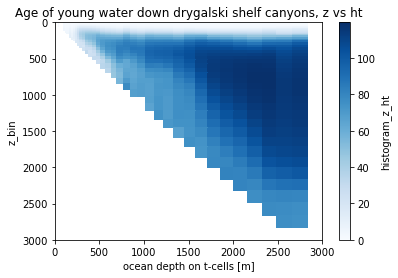

In [25]:

ds = section
#ds = ds.where(ds.y > 1+0.4*ds.x).where(ds.y < 2+0.4*ds.x).where(ds.y < - 0.1*ds.x -86.8)
#ds = ds.where(ds.y > -73.5).where(ds.y < -72)
#ds = ds.where(ds.y > -72).where(ds.y < -70.5).where(ds.x < -187 ).where(ds.x > -189)
ds = ds.where(ds.y > -72).where(ds.y < -69.5).where(ds.x < -187 ).where(ds.x > -189)
ds = ds.where(ds1 < 90)
#ds = ds.interp(st_ocean = np.linspace(0,2600,260))
htbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
zbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
#htbins = np.append(np.linspace(0,1000,30),np.linspace(1000,3000,10))
#zbins = np.append(np.linspace(0,1000,30),np.linspace(1000,3000,10))
dVol = ds.volume.where(~np.isnan(ds.volume))
groupings = histogram(ds.z.where(~np.isnan(ds.age_global)), ds.ht.where(~np.isnan(ds.age_global)), bins = [zbins, htbins],
                      weights = ds.age_global.where(~np.isnan(ds.age_global))*dVol)/histogram(ds.z.where(~np.isnan(ds.age_global)), 
                    ds.ht.where(~np.isnan(ds.age_global)), bins = [zbins, htbins],
                      weights = dVol)
#, dim = ['ht'] weights = )# .groupby('ht')
#coord_mean

groupings.plot(cmap = 'Blues', xlim=(0,3000), ylim = (3000,0))#mean(dim = 'xt_ocean'#.plot()
plt.title('Age of young water down drygalski shelf canyons, z vs ht')

Using the data of the above array we change the y axis coordinates to be the corresponding distance we worked out earlier

In [26]:
da_new = xr.DataArray(groupings.sel(ht_bin = slice(0,2700)).values, dims=['z_bin','distance'],
                           coords={'z_bin': groupings.z_bin,
                                   'distance':np.nan_to_num(sorted(j[0:58]))-8205})

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Age of young water followed down the Drygalski shelf canyons')

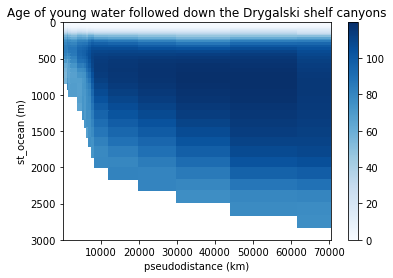

In [28]:
da_new.plot(cmap = 'Blues', xlim = (10, 70500), ylim = (3000,0))
plt.ylabel('st_ocean (m)')
plt.xlabel('pseudodistance (km)')
plt.title('Age of young water followed down the Drygalski shelf canyons')

Now we repeat the above but bin by distance rather than depth, since the depth is roughly constant along the shelf.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true

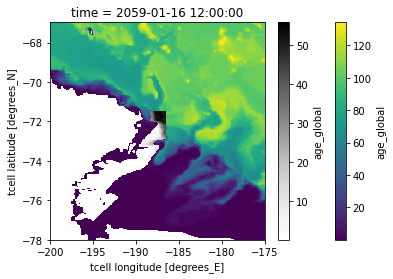

In [68]:
#Now repeat for shallower bit and bin by distance

#making the mask

ds = section
ds1 = ds.where(ds.z > ds.ht-100)
ds1 = ds1.age_global.isel(time = 0).mean('st_ocean')
ds1.plot()

ds = ds.where(ds.y > 1+0.4*ds.x).where(ds.y < 4+0.4*ds.x).where(ds.y < -71.5).where(ds.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
ds = ds.where(ds.ht > 500)
ds.age_global.isel(time = 0).mean('st_ocean').plot(cmap = 'Greys')

In [99]:
ds = section
ds1 = ds.where(ds.z > ds.ht-100)
ds1 = ds1.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > -72).where(ds.y < -69.5).where(ds.x < -186 ).where(ds.x > -188.5)
ds = ds.where(ds1 < 95)
ds = ds.where(ds.ht > 800)
mask_ocean1 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land1 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

#DRYGALSKI SHELF
ds = section
ds = ds.where(ds.z > ds.ht-100)
ds1 = ds.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > 1+0.4*ds.x).where(ds.y < 4+0.4*ds.x).where(ds.y < -71).where(ds.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
#ds = ds.where(ds1<50)
ds = ds.where(ds.ht > 500)
ds = ds.where(np.sqrt((ds.x+190)**2+(ds.y+72)**2)>1)
mask_ocean2 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land2 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  


#DRYGALSKI CONNECTION
ds = section
ds = ds.where(ds.z > ds.ht-100)
ds1 = ds.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > 1+0.4*ds.x).where(ds.y < 4+0.4*ds.x).where(ds.y >-72.5).where(ds.y <-69).where(ds.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
ds = ds.where(ds1<50)
ds = ds.where(ds.ht > 450)
ds = ds.where(ds.x >-187.8)
#ds.age_global.isel(time=0).mean('st_ocean').plot()
mask_ocean3 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land3 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

#DRYGALSKI EXTENSION
ds = section
ds = ds.where(ds.y < -68).where(ds.y>-69.75).where(ds.x>-190).where(ds.x<-187)
#ds.age_global.isel(time=0).mean('st_ocean').plot()
mask_ocean4 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land4 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

mask_array = mask_ocean1 + mask_land1 +mask_ocean2 + mask_land2 +mask_ocean3 + mask_land3 +mask_ocean4 + mask_land4
ds = section
ds = ds.where(mask_array > 4).where(ds1<50).where(ds.y < -72)
ds = ds.assign(distance = lambda ds :-ds.dzt*(np.sqrt(((ds.xt_ocean + 173)*10*(5556.065+ds.dxt)/2)**2+((ds.yt_ocean+60)*10*(5556.065+ds.dyt)/2)**2))/ds.dzt+877194)#.load()


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


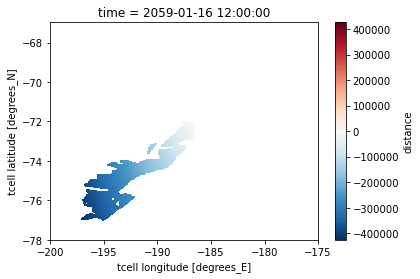

In [93]:
ds2 = ds.distance.isel(time = 0).mean('st_ocean')
ds2.plot()

In [100]:
distancebins_shelf = np.linspace(np.nanmin(ds.distance.values),np.nanmax(ds.distance.values),200)
zbins_shelf = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
#htbins = np.append(np.linspace(0,1000,30),np.linspace(1000,3000,10))
#zbins = np.append(np.linspace(0,1000,30),np.linspace(1000,3000,10))
dVol = ds.volume.where(~np.isnan(ds.volume))
groupings_shelf = histogram(ds.z.where(~np.isnan(ds.age_global)), ds.distance.where(~np.isnan(ds.age_global)), bins = [zbins_shelf, distancebins_shelf],
                      weights = ds.age_global.where(~np.isnan(ds.age_global))*dVol)/histogram(ds.z.where(~np.isnan(ds.age_global)), 
                    ds.distance.where(~np.isnan(ds.age_global)), bins = [zbins_shelf, distancebins_shelf],
                      weights = dVol)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return fun

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

Text(0.5, 1.0, 'Annual mean properties of young water followed down the Drygalski shelf canyons')

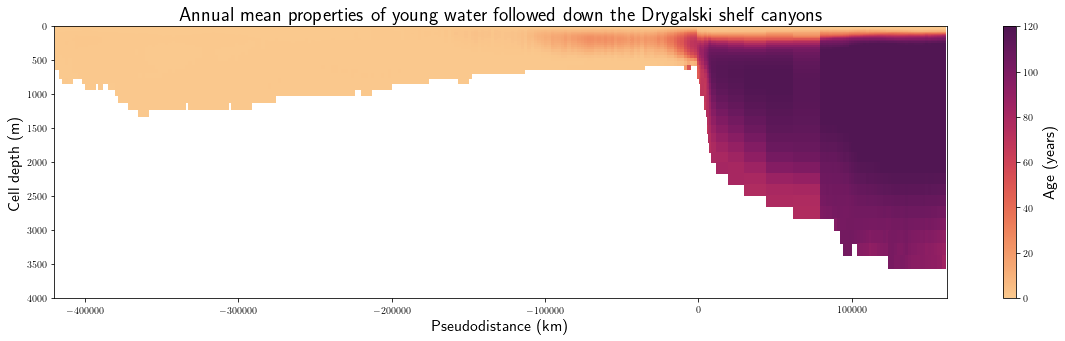

In [101]:

plt.figure(figsize = (20,5))
#groupings.plot(cmap = 'Blues', ylim = (3000,0), xlim=(2,15))#, xlim=(0,3000), )#mean(dim = 'xt_ocean'#.plot()
#plt.title('Age of drygalski, z vs pseudodistance')

cmap = cmocean.cm.matter
newcmap = cmocean.tools.crop_by_percent(cmap, 20, which='both', N=None)
#da_new.sel(distance = slice(20.1,21.6)).plot(cmap = 'Blues',  ylim = (3000,0), vmax = 120, xlim = (11.8,21.6))
groupings_shelf.sel(distance_bin = slice(-420000,-0)).plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmax = 120)
#groupings_ext.plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmax = 120)
#groupings_con.plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmax = 120)#.sel(distance_bin = slice(-20000,10))

CS = da_new.sel(distance = slice(0, 70500)).plot(cmap = newcmap,  ylim = (4000,0), vmax = 120, xlim = (-420000,162000), add_colorbar = False)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('Age (years)', fontsize = 16)
plt.ylabel('Cell depth (m)', fontsize = 16)
plt.xlabel('Pseudodistance (km)', fontsize = 16)
plt.title('Annual mean properties of young water followed down the Drygalski shelf canyons', fontsize = 20)

# Transect anomalies for the whole year on one plot

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return fun

0


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

1


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return

2


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

3


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

4


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return

5


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

6


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

7


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

9


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

10


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

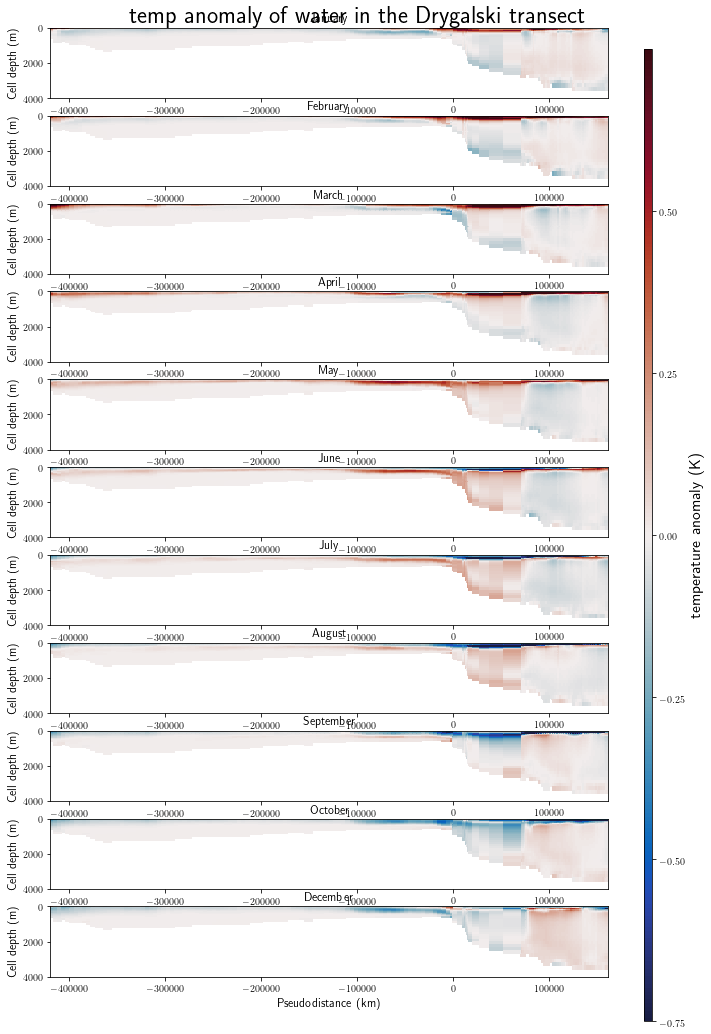

In [44]:
plt.rc('text', usetex=True)
Months = np.array(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])


##SHELF##

ds = section
ds1 = ds.where(ds.z > ds.ht-100)
ds1 = ds1.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > -72).where(ds.y < -69.5).where(ds.x < -186 ).where(ds.x > -188.5)
ds = ds.where(ds1 < 95)
ds = ds.where(ds.ht > 800)
mask_ocean1 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land1 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

#DRYGALSKI SHELF
ds = section
ds = ds.where(ds.z > ds.ht-100)
ds1 = ds.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > 1+0.4*ds.x).where(ds.y < 4+0.4*ds.x).where(ds.y < -71).where(ds.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
#ds = ds.where(ds1<50)
ds = ds.where(ds.ht > 500)
ds = ds.where(np.sqrt((ds.x+190)**2+(ds.y+72)**2)>1)
mask_ocean2 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land2 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  


#DRYGALSKI CONNECTION
ds = section
ds = ds.where(ds.z > ds.ht-100)
ds1 = ds.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > 1+0.4*ds.x).where(ds.y < 4+0.4*ds.x).where(ds.y >-72.5).where(ds.y <-69).where(ds.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
ds = ds.where(ds1<50)
ds = ds.where(ds.ht > 450)
ds = ds.where(ds.x >-187.8)
#ds.age_global.isel(time=0).mean('st_ocean').plot()
mask_ocean3 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land3 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

#DRYGALSKI EXTENSION
ds = section
ds = ds.where(ds.y < -68).where(ds.y>-69.75).where(ds.x>-190).where(ds.x<-187)
#ds.age_global.isel(time=0).mean('st_ocean').plot()
mask_ocean4 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land4 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

mask_array = mask_ocean1 + mask_land1 +mask_ocean2 + mask_land2 +mask_ocean3 + mask_land3 +mask_ocean4 + mask_land4
ds2 = section
ds2 = ds2.where(mask_array > 4).where(ds1<50).where(ds2.y < -72)
ds2 = ds2.assign(distance = lambda ds2 :-ds2.dzt*(np.sqrt(((ds2.xt_ocean + 173)*10*(5556.065+ds2.dxt)/2)**2+((ds2.yt_ocean+60)*10*(5556.065+ds2.dyt)/2)**2))/ds2.dzt+877194)#.load()

#OLD SHELF
# ds2 = section
# ds2 = ds2.where(ds2.y > 1+0.4*ds2.x).where(ds2.y < 4+0.4*ds2.x).where(ds2.y < -72.1).where(ds2.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
# ds2 = ds2.where(ds2.ht > 500)
# ds2 = ds2.where(ds1<50)
# ds2 = ds2.assign(distance = lambda ds2 :-ds2.dzt*(np.sqrt(((ds2.xt_ocean + 173)*10*(5556.065+ds2.dxt)/2)**2+((ds2.yt_ocean+60)*10*(5556.065+ds2.dyt)/2)**2))/ds2.dzt+877194+4000)#.load()

distancebins_shelf = np.linspace(np.nanmin(ds2.distance.values),np.nanmax(ds2.distance.values),100)
zbins_shelf = ds2.sel(st_ocean = slice(0,5000)).st_ocean.values

##CONNECTION##
ds3 = section
ds3 = ds3.where(ds3.y > 1+0.4*ds3.x).where(ds3.y < 4+0.4*ds3.x).where(ds3.y >-72.5).where(ds3.y <-69).where(ds3.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
ds3 = ds3.where(ds1<50)
#ds = ds.where(ds.x>-187.8)
ds3 = ds3.where(ds.ht > 450)
#ds = ds.assign(distance = lambda ds :ds.dzt*(np.sqrt((ds.xt_ocean + 200)**2+(ds.yt_ocean+98)**2))/ds.dzt)#.load()
ds3 = ds3.assign(distance = lambda ds3 :-ds3.dzt*(np.sqrt(((ds3.xt_ocean + 187)*10*(5556.065+ds3.dxt)/2)**2+((ds3.yt_ocean+60)*10*(5556.065+ds3.dyt)/2)**2))/ds3.dzt+102000+1360+513209-12000)#.load()

distancebins_con = np.linspace(np.nanmin(ds3.distance.values),np.nanmax(ds3.distance.values), 12)
zbins_con = ds3.sel(st_ocean = slice(0,5000)).st_ocean.values

##EXTENSION##
ds4 = section
ds4 = ds4.where(ds4.y < -68).where(ds4.y>-69.75).where(ds4.x>-189).where(ds4.x<-187)
#ds = ds.assign(distance = lambda ds :ds.dzt*(np.sqrt((ds.xt_ocean + 200)**2+(ds.yt_ocean+98)**2))/ds.dzt)#.load()
ds4 = ds4.assign(distance = lambda ds4 :-ds4.dzt*(np.sqrt(((ds4.xt_ocean + 188)*10*(5556.065+ds4.dxt)/2)**2+((ds4.yt_ocean+60)*10*(5556.065+ds4.dyt)/2)**2))/ds4.dzt+615325+8200-51396)#.load()
distancebins_ext = np.linspace(np.nanmin(ds4.distance.values),np.nanmax(ds4.distance.values),50)
zbins_ext = ds4.sel(st_ocean = slice(0,5000)).st_ocean.values

##BATHYMETRY BIT##
ds = section#.isel(time = 0)
ds1 = ds.where(ds.z > ds.ht-100)
ds1 = ds1.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > -72).where(ds.y < -69.5).where(ds.x < -186 ).where(ds.x > -188)
ds = ds.where(ds1 < 90)
ds = ds.where(ds.ht > 700)
ds = ds.assign(distance = lambda ds :-ds.dzt*(np.sqrt(((ds.xt_ocean + 188)*10*(5556.065+ds.dxt)/2)**2+((ds.yt_ocean+60)*10*(5556.065+ds.dyt)/2)**2))/ds.dzt+615325)#.load()

sbins = np.linspace(0,122136,70)
tbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
dVol = ds.volume.where(~np.isnan(ds.volume))
hDV = histogram(ds.distance.where(~np.isnan(ds.volume)), ds.ht.where(~np.isnan(ds.volume)), bins = [sbins, tbins])#, weights = dVol)
bins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
h = histogram(hDV.ht_bin, bins=[bins], weights = hDV.distance_bin*hDV)/histogram(hDV.ht_bin, bins=[bins], weights = hDV)
p = h.values
j = np.zeros(p.size)
j[0] = p[0]
j[-1]=p[-1]
for i in np.arange(1, p.size - 1, 1):
    j[i]= np.mean(p[i-2:i+2])

htbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
zbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
dsi = ds

dVol = dsi.volume.where(~np.isnan(dsi.volume))
groupings = histogram(dsi.z.where(~np.isnan(dsi.age_global)), dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dsi.temp.where(~np.isnan(dsi.age_global))*dVol)/histogram(dsi.z.where(~np.isnan(dsi.age_global)), 
                    dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dVol)

da_new_av = xr.DataArray(groupings.sel(ht_bin = slice(0,2700)).values, dims=['z_bin','distance'],
                           coords={'z_bin': groupings.z_bin,
                                   'distance':sorted(np.nan_to_num(j[0:58]))})


ds2i = ds2
dVol2 = ds2i.volume.where(~np.isnan(ds2i.volume))
groupings_shelf_av = histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins_shelf, distancebins_shelf],
                      weights = ds2i.temp.where(~np.isnan(ds2i.age_global))*dVol2)/histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), 
                    ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins_shelf, distancebins_shelf],
                      weights = dVol2)
ds4i = ds4
dVol4 = ds4i.volume.where(~np.isnan(ds4i.volume))
groupings_ext_av = histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins_ext, distancebins_ext],
                      weights = ds4i.temp.where(~np.isnan(ds4i.age_global))*dVol4)/histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), 
                    ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins_ext, distancebins_ext],
                      weights = dVol4)

newcmap = cmocean.cm.balance
#newcmap = cmocean.tools.crop_by_percent(cmap, 20, which='both', N=None)
fig = plt.figure(figsize=(10,15))
plt.suptitle('temp anomaly of water in the Drygalski transect', fontsize=24, fontweight='bold', y = 0.99)

for i in np.arange(0,11,1):
    ax = fig.add_subplot(12, 1, i+1)
    dsi = ds.isel(time = i)

    dVol = dsi.volume.where(~np.isnan(dsi.volume))
    groupings = histogram(dsi.z.where(~np.isnan(dsi.age_global)), dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dsi.temp.where(~np.isnan(dsi.age_global))*dVol)/histogram(dsi.z.where(~np.isnan(dsi.age_global)), 
                    dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dVol)

    da_new = xr.DataArray(groupings.sel(ht_bin = slice(0,2700)).values, dims=['z_bin','distance'],
                           coords={'z_bin': groupings.z_bin,
                                   'distance':sorted(np.nan_to_num(j[0:58]))})


    ds2i = ds2.isel(time = i)
    dVol2 = ds2i.volume.where(~np.isnan(ds2i.volume))
    groupings_shelf = histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins_shelf, distancebins_shelf],
                      weights = ds2i.temp.where(~np.isnan(ds2i.age_global))*dVol2)/histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), 
                    ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins_shelf, distancebins_shelf],
                      weights = dVol2)
    ds4i = ds4.isel(time = i)
    dVol4 = ds4i.volume.where(~np.isnan(ds4i.volume))
    groupings_ext = histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins_ext, distancebins_ext],
                      weights = ds4i.temp.where(~np.isnan(ds4i.age_global))*dVol4)/histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), 
                    ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins_ext, distancebins_ext],
                      weights = dVol4)
    (groupings_shelf-groupings_shelf_av).sel(distance_bin = slice(-420000,-0)).plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmin = -0.75, vmax = 0.75)
    (groupings_ext-groupings_ext_av).plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmin = -0.75, vmax = 0.75)
    #groupings_con.plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmax = 120)#.sel(distance_bin = slice(-20000,10))
    CS = (da_new-da_new_av).sel(distance = slice(0, 70500)).plot(cmap = newcmap,  ylim = (4000,0), vmin = -0.75, vmax = 0.75, xlim = (-420000,162000), add_colorbar = False)
    ax.set_xlabel('', fontsize = 1)
    ax.set_ylabel('Cell depth (m)', fontsize = 12)
    ax.set_title(Months[i], fontsize = 12)
    print(i)
i = 11
ax = fig.add_subplot(12, 1, i)
dsi = ds.isel(time = i)

dVol = dsi.volume.where(~np.isnan(dsi.volume))
groupings = histogram(dsi.z.where(~np.isnan(dsi.age_global)), dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dsi.temp.where(~np.isnan(dsi.age_global))*dVol)/histogram(dsi.z.where(~np.isnan(dsi.age_global)), 
                    dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dVol)

da_new = xr.DataArray(groupings.sel(ht_bin = slice(0,2700)).values, dims=['z_bin','distance'],
                           coords={'z_bin': groupings.z_bin,
                                   'distance':sorted(np.nan_to_num(j[0:58]))})


ds2i = ds2.isel(time = i)
dVol2 = ds2i.volume.where(~np.isnan(ds2i.volume))
groupings_shelf = histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins_shelf, distancebins_shelf],
                      weights = ds2i.temp.where(~np.isnan(ds2i.age_global))*dVol2)/histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), 
                    ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins_shelf, distancebins_shelf],
                      weights = dVol2)
ds4i = ds4.isel(time = i)
dVol4 = ds4i.volume.where(~np.isnan(ds4i.volume))
groupings_ext = histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins_ext, distancebins_ext],
                      weights = ds4i.temp.where(~np.isnan(ds4i.age_global))*dVol4)/histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), 
                    ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins_ext, distancebins_ext],
                      weights = dVol4)
(groupings_shelf-groupings_shelf_av).sel(distance_bin = slice(-420000,-0)).plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmin = -0.75, vmax = 0.75)
(groupings_ext-groupings_ext_av).plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmin = -0.75, vmax = 0.75)
#groupings_con.plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmax = 120)#.sel(distance_bin = slice(-20000,10))
CS = (da_new-da_new_av).sel(distance = slice(0, 70500)).plot(cmap = newcmap,  ylim = (4000,0), vmin = -0.75, vmax = 0.75, xlim = (-420000,162000), add_colorbar = False)

ax.set_ylabel('Cell depth (m)', fontsize = 12)
ax.set_title(Months[i], fontsize = 12)

ax.set_xlabel('Pseudodistance (km)', fontsize = 12)



#plt.savefig('Drygalski_DSWTracking_age_refinedtransect')
#plt.suptitle('Age of water in the bottom 100m of the ocean for the Ross Sea region', fontsize=16, fontweight='bold')
cb_ax = fig.add_axes([0.9, 0.05, 0.01, 0.9])
#cb_ax.anchor((1,0.5))

# axins = inset_axes(ax2,
#                    width="5%",  # width = 5% of parent_bbox width
#                    height="100%",  # height : 50%
#                    loc='left',
#                    bbox_to_anchor=(1.05, 0., 1, 1),
#                    bbox_transform=ax2.transAxes,
#                    borderpad=0,
#                    )
cbar = fig.colorbar(CS, cax=cb_ax, cmap = newcmap)
cbar.set_ticks(np.arange(-0.75, 0.75, 0.25))
cbar.ax.set_ylabel('temperature anomaly (K)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.97, right = 0.85, hspace = 0.25)
fig.savefig('temp_drygalski_km1_anomaly.png')

# GIF code for transects (plot of one month at a time)

In [8]:
plt.rc('text', usetex=False)
Months = np.array(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])


##SHELF##

ds = section
ds1 = ds.where(ds.z > ds.ht-100)
ds1 = ds1.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > -72).where(ds.y < -69.5).where(ds.x < -186 ).where(ds.x > -188.5)
ds = ds.where(ds1 < 95)
ds = ds.where(ds.ht > 800)
mask_ocean1 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land1 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

#DRYGALSKI SHELF
ds = section
ds = ds.where(ds.z > ds.ht-100)
ds1 = ds.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > 1+0.4*ds.x).where(ds.y < 4+0.4*ds.x).where(ds.y < -71).where(ds.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
#ds = ds.where(ds1<50)
ds = ds.where(ds.ht > 500)
ds = ds.where(np.sqrt((ds.x+190)**2+(ds.y+72)**2)>1)
mask_ocean2 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land2 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  


#DRYGALSKI CONNECTION
ds = section
ds = ds.where(ds.z > ds.ht-100)
ds1 = ds.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > 1+0.4*ds.x).where(ds.y < 4+0.4*ds.x).where(ds.y >-72.5).where(ds.y <-69).where(ds.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
ds = ds.where(ds1<50)
ds = ds.where(ds.ht > 450)
ds = ds.where(ds.x >-187.8)
#ds.age_global.isel(time=0).mean('st_ocean').plot()
mask_ocean3 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land3 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

#DRYGALSKI EXTENSION
ds = section
ds = ds.where(ds.y < -68).where(ds.y>-69.75).where(ds.x>-190).where(ds.x<-187)
#ds.age_global.isel(time=0).mean('st_ocean').plot()
mask_ocean4 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land4 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

mask_array = mask_ocean1 + mask_land1 +mask_ocean2 + mask_land2 +mask_ocean3 + mask_land3 +mask_ocean4 + mask_land4
ds2 = section
ds2 = ds2.where(mask_array > 4).where(ds1<50).where(ds2.y < -72)
ds2 = ds2.assign(distance = lambda ds2 :(-ds2.dzt*(np.sqrt(((ds2.xt_ocean + 173)*10*(5556.065+ds2.dxt)/2)**2+((ds2.yt_ocean+60)*10*(5556.065+ds2.dyt)/2)**2))/ds2.dzt+877194)/1000)#.load()

#OLD SHELF
# ds2 = section
# ds2 = ds2.where(ds2.y > 1+0.4*ds2.x).where(ds2.y < 4+0.4*ds2.x).where(ds2.y < -72.1).where(ds2.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
# ds2 = ds2.where(ds2.ht > 500)
# ds2 = ds2.where(ds1<50)
# ds2 = ds2.assign(distance = lambda ds2 :-ds2.dzt*(np.sqrt(((ds2.xt_ocean + 173)*10*(5556.065+ds2.dxt)/2)**2+((ds2.yt_ocean+60)*10*(5556.065+ds2.dyt)/2)**2))/ds2.dzt+877194+4000)#.load()

distancebins_shelf = np.linspace(np.nanmin(ds2.distance.values),np.nanmax(ds2.distance.values),100)
zbins_shelf = ds2.sel(st_ocean = slice(0,5000)).st_ocean.values

##CONNECTION##
ds3 = section
ds3 = ds3.where(ds3.y > 1+0.4*ds3.x).where(ds3.y < 4+0.4*ds3.x).where(ds3.y >-72.5).where(ds3.y <-69).where(ds3.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
ds3 = ds3.where(ds1<50)
#ds = ds.where(ds.x>-187.8)
ds3 = ds3.where(ds.ht > 450)
#ds = ds.assign(distance = lambda ds :ds.dzt*(np.sqrt((ds.xt_ocean + 200)**2+(ds.yt_ocean+98)**2))/ds.dzt)#.load()
ds3 = ds3.assign(distance = lambda ds3 :(-ds3.dzt*(np.sqrt(((ds3.xt_ocean + 187)*10*(5556.065+ds3.dxt)/2)**2+((ds3.yt_ocean+60)*10*(5556.065+ds3.dyt)/2)**2))/ds3.dzt+102000+1360+513209-12000)/1000)#.load()

distancebins_con = np.linspace(np.nanmin(ds3.distance.values),np.nanmax(ds3.distance.values), 12)
zbins_con = ds3.sel(st_ocean = slice(0,5000)).st_ocean.values

##EXTENSION##
ds4 = section
ds4 = ds4.where(ds4.y < -68).where(ds4.y>-69.75).where(ds4.x>-189).where(ds4.x<-187)
#ds = ds.assign(distance = lambda ds :ds.dzt*(np.sqrt((ds.xt_ocean + 200)**2+(ds.yt_ocean+98)**2))/ds.dzt)#.load()
ds4 = ds4.assign(distance = lambda ds4 :(-ds4.dzt*(np.sqrt(((ds4.xt_ocean + 188)*10*(5556.065+ds4.dxt)/2)**2+((ds4.yt_ocean+60)*10*(5556.065+ds4.dyt)/2)**2))/ds4.dzt+615325+8200-51396)/1000)#.load()
distancebins_ext = np.linspace(np.nanmin(ds4.distance.values),np.nanmax(ds4.distance.values),50)
zbins_ext = ds4.sel(st_ocean = slice(0,5000)).st_ocean.values

##BATHYMETRY BIT##
ds = section#.isel(time = 0)
ds1 = ds.where(ds.z > ds.ht-100)
ds1 = ds1.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > -72).where(ds.y < -69.5).where(ds.x < -186 ).where(ds.x > -188)
ds = ds.where(ds1 < 90)
ds = ds.where(ds.ht > 700)
ds = ds.assign(distance = lambda ds :(-ds.dzt*(np.sqrt(((ds.xt_ocean + 188)*10*(5556.065+ds.dxt)/2)**2+((ds.yt_ocean+60)*10*(5556.065+ds.dyt)/2)**2))/ds.dzt+615325)/1000)#.load()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return fun

In [9]:
sbins = np.linspace(np.nanmin(ds.distance.values),np.nanmax(ds.distance.values),70)#np.linspace(0,122.136,70)
tbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
dVol = ds.volume.where(~np.isnan(ds.volume))
hDV = histogram(ds.distance.where(~np.isnan(ds.volume)), ds.ht.where(~np.isnan(ds.volume)), bins = [sbins, tbins])#, weights = dVol)
bins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
h = histogram(hDV.ht_bin, bins=[bins], weights = hDV.distance_bin*hDV)/histogram(hDV.ht_bin, bins=[bins], weights = hDV)
p = h.values
j = np.zeros(p.size)
j[0] = p[0]
j[-1]=p[-1]
for i in np.arange(1, p.size - 1, 1):
    j[i]= np.mean(p[i-2:i+2])

htbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
zbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
dsi = ds

dVol = dsi.volume.where(~np.isnan(dsi.volume))
groupings = histogram(dsi.z.where(~np.isnan(dsi.age_global)), dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dsi.pot_rho_2.where(~np.isnan(dsi.age_global))*dVol)/histogram(dsi.z.where(~np.isnan(dsi.age_global)), 
                    dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dVol)

da_new_av = xr.DataArray(groupings.sel(ht_bin = slice(0,2700)).values, dims=['z_bin','distance'],
                           coords={'z_bin': groupings.z_bin,
                                   'distance':sorted(np.nan_to_num(j[0:58]))})

ds2i = ds2
dVol2 = ds2i.volume.where(~np.isnan(ds2i.volume))
groupings_shelf_av = histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins_shelf, distancebins_shelf],
                      weights = ds2i.pot_rho_2.where(~np.isnan(ds2i.age_global))*dVol2)/histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), 
                    ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins_shelf, distancebins_shelf],
                      weights = dVol2)
ds4i = ds4
dVol4 = ds4i.volume.where(~np.isnan(ds4i.volume))
groupings_ext_av = histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins_ext, distancebins_ext],
                      weights = ds4i.pot_rho_2.where(~np.isnan(ds4i.age_global))*dVol4)/histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), 
                    ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins_ext, distancebins_ext],
                      weights = dVol4)

newcmap = cmocean.cm.balance
#newcmap = cmocean.tools.crop_by_percent(cmap, 20, which='both', N=None)
#fig = plt.figure(figsize=(10,5))
#plt.suptitle('temp anomaly of water in the Drygalski transect', fontsize=24, fontweight='bold', y = 0.99)

for i in np.arange(0,12,1):
    fig = plt.figure(figsize=(10,5))
    dsi = ds.isel(time = i)

    dVol = dsi.volume.where(~np.isnan(dsi.volume))
    groupings = histogram(dsi.z.where(~np.isnan(dsi.age_global)), dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dsi.pot_rho_2.where(~np.isnan(dsi.age_global))*dVol)/histogram(dsi.z.where(~np.isnan(dsi.age_global)), 
                    dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dVol)

    da_new = xr.DataArray(groupings.sel(ht_bin = slice(0,2700)).values, dims=['z_bin','distance'],
                           coords={'z_bin': groupings.z_bin,
                                   'distance':sorted(np.nan_to_num(j[0:58]))})


    ds2i = ds2.isel(time = i)
    dVol2 = ds2i.volume.where(~np.isnan(ds2i.volume))
    groupings_shelf = histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins_shelf, distancebins_shelf],
                      weights = ds2i.pot_rho_2.where(~np.isnan(ds2i.age_global))*dVol2)/histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), 
                    ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins_shelf, distancebins_shelf],
                      weights = dVol2)
    ds4i = ds4.isel(time = i)
    dVol4 = ds4i.volume.where(~np.isnan(ds4i.volume))
    groupings_ext = histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins_ext, distancebins_ext],
                      weights = ds4i.pot_rho_2.where(~np.isnan(ds4i.age_global))*dVol4)/histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), 
                    ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins_ext, distancebins_ext],
                      weights = dVol4)
    (groupings_shelf-groupings_shelf_av).sel(distance_bin = slice(-420,-0)).plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmin = -0.2, vmax = 0.2)
    (groupings_ext-groupings_ext_av).plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmin = -0.2, vmax = 0.2)
    #groupings_con.plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmax = 120)#.sel(distance_bin = slice(-20000,10))
    CS = (da_new-da_new_av).sel(distance = slice(0, 70.500)).plot(cmap = newcmap,  ylim = (4000,0), vmin = -0.2, vmax = 0.2, xlim = (-420,162), add_colorbar = False)
    plt.xlabel('Pseudodistance (km)', fontsize = 12)
    plt.ylabel('Cell depth (m)', fontsize = 12)
    plt.title(Months[i], fontsize = 12)
    cb_ax = fig.add_axes([0.9, 0.05, 0.01, 0.9])
    cbar = fig.colorbar(CS, cax=cb_ax, cmap = newcmap)
    cbar.set_ticks(np.arange(-0.2, 0.2, 0.1))
    cbar.ax.set_ylabel('density anomaly (K)', fontsize = 12)
    fig.savefig('drygalskidensityanomaly'+str(i)+'.png')
    plt.clf()
    print(i)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return fun

0


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

1


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

2


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

3


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

4


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

5


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

6


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return

7


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

9


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

10


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  ret

11


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

## A combined plot of the Drygalski and Joides transect properties used in the final report

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return fun

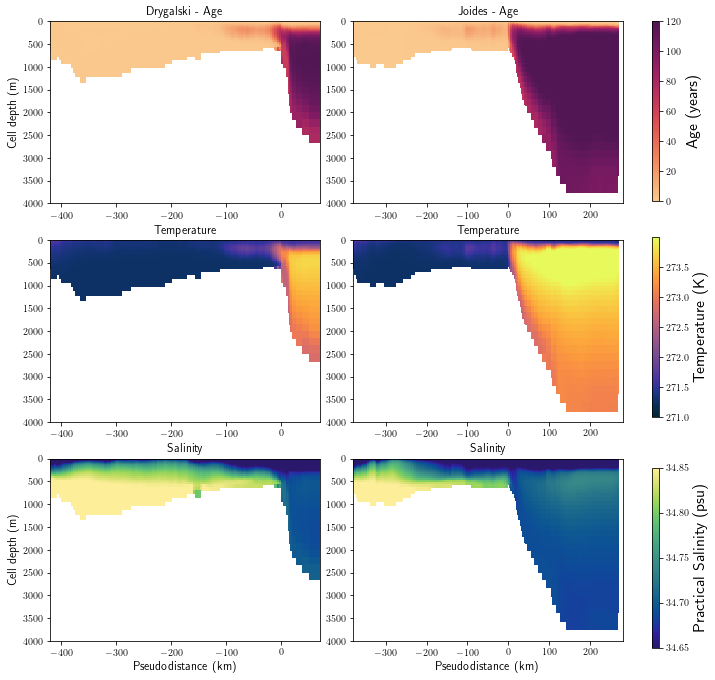

In [14]:
plt.rc('text', usetex=True)
##DEFINING DRYGALSKI SECTIONS##


##SHELF##

ds = section
ds1 = ds.where(ds.z > ds.ht-100)
ds1 = ds1.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > -72).where(ds.y < -69.5).where(ds.x < -186 ).where(ds.x > -188.5)
ds = ds.where(ds1 < 95)
ds = ds.where(ds.ht > 800)
mask_ocean1 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land1 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

#DRYGALSKI SHELF
ds = section
ds = ds.where(ds.z > ds.ht-100)
ds1 = ds.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > 1+0.4*ds.x).where(ds.y < 4+0.4*ds.x).where(ds.y < -71).where(ds.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
#ds = ds.where(ds1<50)
ds = ds.where(ds.ht > 500)
ds = ds.where(np.sqrt((ds.x+190)**2+(ds.y+72)**2)>1)
mask_ocean2 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land2 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  


#DRYGALSKI CONNECTION
ds = section
ds = ds.where(ds.z > ds.ht-100)
ds1 = ds.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > 1+0.4*ds.x).where(ds.y < 4+0.4*ds.x).where(ds.y >-72.5).where(ds.y <-69).where(ds.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
ds = ds.where(ds1<50)
ds = ds.where(ds.ht > 450)
ds = ds.where(ds.x >-187.8)
#ds.age_global.isel(time=0).mean('st_ocean').plot()
mask_ocean3 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land3 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

#DRYGALSKI EXTENSION
ds = section
ds = ds.where(ds.y < -68).where(ds.y>-69.75).where(ds.x>-190).where(ds.x<-187)
#ds.age_global.isel(time=0).mean('st_ocean').plot()
mask_ocean4 = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.salt.isel(time=0).mean('st_ocean'))  
mask_land4 = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.salt.isel(time=0).mean('st_ocean'))  

mask_array = mask_ocean1 + mask_land1 +mask_ocean2 + mask_land2 +mask_ocean3 + mask_land3 +mask_ocean4 + mask_land4
ds2 = section
ds2 = ds2.where(mask_array > 4).where(ds1<50).where(ds2.y < -72)
ds2 = ds2.assign(distance = lambda ds2 :(-ds2.dzt*(np.sqrt(((ds2.xt_ocean + 173)*10*(5556.065+ds2.dxt)/2)**2+((ds2.yt_ocean+60)*10*(5556.065+ds2.dyt)/2)**2))/ds2.dzt+877194)/1000)#.load()

#OLD SHELF
# ds2 = section
# ds2 = ds2.where(ds2.y > 1+0.4*ds2.x).where(ds2.y < 4+0.4*ds2.x).where(ds2.y < -72.1).where(ds2.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
# ds2 = ds2.where(ds2.ht > 500)
# ds2 = ds2.where(ds1<50)
# ds2 = ds2.assign(distance = lambda ds2 :-ds2.dzt*(np.sqrt(((ds2.xt_ocean + 173)*10*(5556.065+ds2.dxt)/2)**2+((ds2.yt_ocean+60)*10*(5556.065+ds2.dyt)/2)**2))/ds2.dzt+877194+4000)#.load()

distancebins2 = np.linspace(np.nanmin(ds2.distance.values),np.nanmax(ds2.distance.values),100)
zbins2 = ds2.sel(st_ocean = slice(0,5000)).st_ocean.values

##CONNECTION##
# ds3 = section
# ds3 = ds3.where(ds3.y > 1+0.4*ds3.x).where(ds3.y < 4+0.4*ds3.x).where(ds3.y >-72.5).where(ds3.y <-69).where(ds3.x < -186.5)# where(ds.y < - 0.1*ds.x -92.8)
# ds3 = ds3.where(ds1<50)
# #ds = ds.where(ds.x>-187.8)
# ds3 = ds3.where(ds.ht > 450)
# #ds = ds.assign(distance = lambda ds :ds.dzt*(np.sqrt((ds.xt_ocean + 200)**2+(ds.yt_ocean+98)**2))/ds.dzt)#.load()
# ds3 = ds3.assign(distance = lambda ds3 :-ds3.dzt*(np.sqrt(((ds3.xt_ocean + 187)*10*(5556.065+ds3.dxt)/2)**2+((ds3.yt_ocean+60)*10*(5556.065+ds3.dyt)/2)**2))/ds3.dzt+102000+1360+513209-12000)#.load()

# distancebins_con = np.linspace(np.nanmin(ds3.distance.values),np.nanmax(ds3.distance.values), 12)
# zbins_con = ds3.sel(st_ocean = slice(0,5000)).st_ocean.values

##EXTENSION##
ds4 = section
ds4 = ds4.where(ds4.y < -68).where(ds4.y>-69.75).where(ds4.x>-189).where(ds4.x<-187)
#ds = ds.assign(distance = lambda ds :ds.dzt*(np.sqrt((ds.xt_ocean + 200)**2+(ds.yt_ocean+98)**2))/ds.dzt)#.load()
ds4 = ds4.assign(distance = lambda ds4 :(-ds4.dzt*(np.sqrt(((ds4.xt_ocean + 188)*10*(5556.065+ds4.dxt)/2)**2+((ds4.yt_ocean+60)*10*(5556.065+ds4.dyt)/2)**2))/ds4.dzt+615325+8200-51396)/1000)#.load()
distancebins4 = np.linspace(np.nanmin(ds4.distance.values),np.nanmax(ds4.distance.values),50)
zbins4 = ds4.sel(st_ocean = slice(0,5000)).st_ocean.values

##BATHYMETRY BIT##
ds = section#.isel(time = 0)
ds1 = ds.where(ds.z > ds.ht-100)
ds1 = ds1.age_global.isel(time = 0).mean('st_ocean')
ds = ds.where(ds.y > -72).where(ds.y < -69.5).where(ds.x < -186 ).where(ds.x > -188)
ds = ds.where(ds1 < 90)
ds = ds.where(ds.ht > 700)
ds = ds.assign(distance = lambda ds :(-ds.dzt*(np.sqrt(((ds.xt_ocean + 188)*10*(5556.065+ds.dxt)/2)**2+((ds.yt_ocean+60)*10*(5556.065+ds.dyt)/2)**2))/ds.dzt+615325)/1000)#.load()

sbins = np.linspace(np.nanmin(ds.distance.values),np.nanmax(ds.distance.values),70)#np.linspace(0,122.136,70)
tbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
dVol = ds.volume.where(~np.isnan(ds.volume))
hDV = histogram(ds.distance.where(~np.isnan(ds.volume)), ds.ht.where(~np.isnan(ds.volume)), bins = [sbins, tbins])#, weights = dVol)
bins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
h = histogram(hDV.ht_bin, bins=[bins], weights = hDV.distance_bin*hDV)/histogram(hDV.ht_bin, bins=[bins], weights = hDV)
p = h.values
j = np.zeros(p.size)
j[0] = p[0]
j[-1]=p[-1]
for i in np.arange(1, p.size - 1, 1):
    j[i]= np.mean(p[i-2:i+2])

htbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
zbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values

cmap = cmocean.cm.matter
newcmap = cmocean.tools.crop_by_percent(cmap, 20, which='both', N=None)

##Drygalski AGE
fig = plt.figure(figsize=(10,10))
#plt.suptitle('Properties of DSW path transects in the Ross Sea', fontsize=24, fontweight='bold', y = 0.99)

dsi = ds
dVol = dsi.volume.where(~np.isnan(dsi.volume))
groupings = histogram(dsi.z.where(~np.isnan(dsi.age_global)), dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dsi.age_global.where(~np.isnan(dsi.age_global))*dVol)/histogram(dsi.z.where(~np.isnan(dsi.age_global)), 
                    dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dVol)
da_new_age = xr.DataArray(groupings.sel(ht_bin = slice(0,2700)).values, dims=['z_bin','distance'],
                           coords={'z_bin': groupings.z_bin,
                                   'distance':sorted(np.nan_to_num(j[0:58]))})


ds2i = ds2
dVol2= ds2i.volume.where(~np.isnan(ds2i.volume))
groupings2_age = histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins2, distancebins2],
                      weights = ds2i.age_global.where(~np.isnan(ds2i.age_global))*dVol2)/histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), 
                    ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins2, distancebins2],
                      weights = dVol2)
ds4i = ds4
dVol4= ds4i.volume.where(~np.isnan(ds4i.volume))
groupings4_age = histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins4, distancebins4],
                      weights = ds4i.age_global.where(~np.isnan(ds4i.age_global))*dVol4)/histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), 
                    ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins4, distancebins4],
                      weights = dVol4)
    
ax = fig.add_subplot(3, 2, 1)
groupings2_age.sel(distance_bin = slice(-420.000,-0)).plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmax = 120)
#groupings4_age.plot(cmap = newcmap, ylim = (4000,0), add_colorbar = False, vmax = 120)
im = da_new_age.sel(distance = slice(0, 70.500)).plot(cmap = newcmap,  ylim = (4000,0), vmax = 120, xlim = (-420.000,70.500), add_colorbar = False)
ax.set_xlabel('', fontsize = 1)
ax.set_ylabel('Cell depth (m)', fontsize = 12)
ax.set_title('Drygalski - Age', fontsize = 12)
cb_ax1 = fig.add_axes([0.91, 0.67, 0.01, 0.25])
cbar1 = fig.colorbar(im, cax=cb_ax1, cmap = newcmap)
cbar1.set_ticks(np.arange(0, 121, 20))
cbar1.ax.set_ylabel('Age (years)', fontsize = 16)


ax = fig.add_subplot(3, 2, 3)
dsi = ds
dVol = dsi.volume.where(~np.isnan(dsi.volume))
groupings = histogram(dsi.z.where(~np.isnan(dsi.age_global)), dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dsi.temp.where(~np.isnan(dsi.age_global))*dVol)/histogram(dsi.z.where(~np.isnan(dsi.age_global)), 
                    dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dVol)
da_new_temp = xr.DataArray(groupings.sel(ht_bin = slice(0,2700)).values, dims=['z_bin','distance'],
                           coords={'z_bin': groupings.z_bin,
                                   'distance':sorted(np.nan_to_num(j[0:58]))})


ds2i = ds2
dVol2= ds2i.volume.where(~np.isnan(ds2i.volume))
groupings2_temp = histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins2, distancebins2],
                      weights = ds2i.temp.where(~np.isnan(ds2i.age_global))*dVol2)/histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), 
                    ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins2, distancebins2],
                      weights = dVol2)
ds4i = ds4
dVol4= ds4i.volume.where(~np.isnan(ds4i.volume))
groupings4_temp = histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins4, distancebins4],
                      weights = ds4i.temp.where(~np.isnan(ds4i.age_global))*dVol4)/histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), 
                    ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins4, distancebins4],
                      weights = dVol4)
    
groupings2_temp.sel(distance_bin = slice(-420.000,-0)).plot(cmap = 'cmo.thermal', ylim = (4000,0), add_colorbar = False, vmin =271, vmax = 274)
#groupings4_temp.plot(cmap = 'cmo.thermal', ylim = (4000,0), add_colorbar = False, vmin =271, vmax = 274)
im = da_new_temp.sel(distance = slice(0, 70.500)).plot(cmap = 'cmo.thermal',  ylim = (4000,0), vmin =271, vmax = 274, xlim = (-420.000,70.500), add_colorbar = False)
ax.set_xlabel('', fontsize = 1)
ax.set_ylabel('', fontsize = 1)
ax.set_title('Temperature', fontsize = 12)

cb_ax2 = fig.add_axes([0.91, 0.37, 0.01, 0.25])
cbar2 = fig.colorbar(im, cax=cb_ax2, cmap = 'cmo.thermal')
cbar2.set_ticks(np.arange(271, 274, 0.5))
cbar2.ax.set_ylabel('Temperature (K)', fontsize = 16)

ax = fig.add_subplot(3, 2, 5)
dsi = ds
dVol = dsi.volume.where(~np.isnan(dsi.volume))
groupings = histogram(dsi.z.where(~np.isnan(dsi.age_global)), dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dsi.salt.where(~np.isnan(dsi.age_global))*dVol)/histogram(dsi.z.where(~np.isnan(dsi.age_global)), 
                    dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dVol)
da_new_salt = xr.DataArray(groupings.sel(ht_bin = slice(0,2700)).values, dims=['z_bin','distance'],
                           coords={'z_bin': groupings.z_bin,
                                   'distance':sorted(np.nan_to_num(j[0:58]))})


ds2i = ds2
dVol2= ds2i.volume.where(~np.isnan(ds2i.volume))
groupings2_salt = histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins2, distancebins2],
                      weights = ds2i.salt.where(~np.isnan(ds2i.age_global))*dVol2)/histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), 
                    ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins2, distancebins2],
                      weights = dVol2)
ds4i = ds4
dVol4= ds4i.volume.where(~np.isnan(ds4i.volume))
groupings4_salt = histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins4, distancebins4],
                      weights = ds4i.salt.where(~np.isnan(ds4i.age_global))*dVol4)/histogram(ds4i.z.where(~np.isnan(ds4i.age_global)), 
                    ds4i.distance.where(~np.isnan(ds4i.age_global)), bins = [zbins4, distancebins4],
                      weights = dVol4)
    
groupings2_salt.sel(distance_bin = slice(-420.000,-0)).plot(cmap = 'cmo.haline', ylim = (4000,0), add_colorbar = False, vmin =34.65, vmax = 34.85)
#groupings4_salt.plot(cmap = 'cmo.haline', ylim = (4000,0), add_colorbar = False, vmin =34.65, vmax = 34.85)
im = da_new_salt.sel(distance = slice(0, 70.500)).plot(cmap = 'cmo.haline',  ylim = (4000,0), vmin =34.65, vmax = 34.85, xlim = (-420.000,70.500), add_colorbar = False)

ax.set_xlabel('Pseudodistance (km)', fontsize = 12)
ax.set_ylabel('Cell depth (m)', fontsize = 12)
ax.set_title('Salinity', fontsize = 12)
cb_ax3 = fig.add_axes([0.91, 0.05, 0.01, 0.25])
cbar3 = fig.colorbar(im, cax=cb_ax3, cmap = 'cmo.haline')
cbar3.set_ticks(np.arange(34.65, 34.85, 0.05))
cbar3.ax.set_ylabel('Practical Salinity (psu)', fontsize = 16)

##DEFINING JOIDES SECTIONS##
ds = section
ds = ds.where(ds.z > ds.ht-100)
ds1 = ds.age_global.isel(time = 0).mean('st_ocean')
ds =section
ds = ds.where(ds.y > -73.5).where(ds.y < -69).where(ds.x < -180 ).where(ds.x > -184)
ds = ds.where(ds1 < 90)
ds = ds.where(ds.y > -0.2+0.4*ds.x)
ds = ds.assign(distance = lambda ds :(-ds.dzt*(np.sqrt(((ds.xt_ocean + 180)*10*(5556.065+ds.dxt)/2)**2+((ds.yt_ocean+60)*10*(5556.065+ds.dyt)/2)**2))/ds.dzt+686430+8041)/1000)#.load()
sbins = np.linspace(np.nanmin(ds.distance.values)-1,np.nanmax(ds.distance.values)+1,70)
tbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
dVol = ds.volume.where(~np.isnan(ds.volume))
hDV = histogram(ds.distance.where(~np.isnan(ds.volume)), ds.ht.where(~np.isnan(ds.volume)), bins = [sbins, tbins])#, weights = dVol)
bins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
h = histogram(hDV.ht_bin, bins=[bins], weights = hDV.distance_bin*hDV)/histogram(hDV.ht_bin, bins=[bins], weights = hDV)
p = h.values
j = np.zeros(p.size)
j[0] = p[0]
j[-1]=p[-1]
for i in np.arange(1, p.size - 1, 1):
    j[i]= np.nanmean(p[i-2:i+2])
htbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
zbins = ds.sel(st_ocean = slice(0,5000)).st_ocean.values
dsi=ds
groupings = histogram(dsi.z.where(~np.isnan(dsi.age_global)), dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dsi.age_global.where(~np.isnan(dsi.age_global))*dVol)/histogram(dsi.z.where(~np.isnan(dsi.age_global)), 
                    dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dVol)
da_new_age = xr.DataArray(groupings.sel(ht_bin = slice(0,2700)).values, dims=['z_bin','distance'],
                           coords={'z_bin': groupings.z_bin,
                                   'distance':sorted(np.nan_to_num(j[0:58]))})
groupings = histogram(dsi.z.where(~np.isnan(dsi.age_global)), dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dsi.temp.where(~np.isnan(dsi.age_global))*dVol)/histogram(dsi.z.where(~np.isnan(dsi.age_global)), 
                    dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dVol)
da_new_temp = xr.DataArray(groupings.sel(ht_bin = slice(0,2700)).values, dims=['z_bin','distance'],
                           coords={'z_bin': groupings.z_bin,
                                   'distance':sorted(np.nan_to_num(j[0:58]))})
groupings = histogram(dsi.z.where(~np.isnan(dsi.age_global)), dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dsi.salt.where(~np.isnan(dsi.age_global))*dVol)/histogram(dsi.z.where(~np.isnan(dsi.age_global)), 
                    dsi.ht.where(~np.isnan(dsi.age_global)), bins = [zbins, htbins],
                      weights = dVol)
da_new_salt = xr.DataArray(groupings.sel(ht_bin = slice(0,2700)).values, dims=['z_bin','distance'],
                           coords={'z_bin': groupings.z_bin,
                                   'distance':sorted(np.nan_to_num(j[0:58]))})



ds2 = section
ds2 = ds2.where(ds2.y > -1+0.4*ds2.x).where(ds2.y < 1+0.4*ds2.x).where(ds2.y < -71.4).where(ds2.y < - 0.1*ds2.x -91.5).where(ds2.x < -183)#)#.where(ds.x < -188)# 

ds2 = ds2.where(ds2.ht > 500)
ds2 = ds2.assign(distance = lambda ds2 :(-ds2.dzt*(np.sqrt(((ds2.xt_ocean + 180)*10*(5556.065+ds2.dxt)/2)**2+((ds2.yt_ocean+60)*10*(5556.065+ds2.dyt)/2)**2))/ds2.dzt+686430+12041)/1000)#.load()
distancebins2 = np.linspace(np.nanmin(ds2.distance.values)-1,np.nanmax(ds2.distance.values)+1,100)
zbins2 = ds2.sel(st_ocean = slice(0,5000)).st_ocean.values
ds2i = ds2
dVol2= ds2i.volume.where(~np.isnan(ds2i.volume))
groupings2_age = histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins2, distancebins2],
                      weights = ds2i.age_global.where(~np.isnan(ds2i.age_global))*dVol2)/histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), 
                    ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins2, distancebins2],
                      weights = dVol2)
groupings2_temp = histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins2, distancebins2],
                      weights = ds2i.temp.where(~np.isnan(ds2i.age_global))*dVol2)/histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), 
                    ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins2, distancebins2],
                      weights = dVol2)
groupings2_salt = histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins2, distancebins2],
                      weights = ds2i.salt.where(~np.isnan(ds2i.age_global))*dVol2)/histogram(ds2i.z.where(~np.isnan(ds2i.age_global)), 
                    ds2i.distance.where(~np.isnan(ds2i.age_global)), bins = [zbins2, distancebins2],
                      weights = dVol2)


ds3 = section
ds3 = ds3.where(ds3.y > -71.3).where(ds3.y < -68).where(ds3.x <-181).where(ds3.x>-183).where(ds3.y > - 0.27*ds3.x -120.2)

#ds = ds.assign(distance = lambda ds :ds.dzt*(np.sqrt((ds.xt_ocean + 190)**2+(ds.yt_ocean+90)**2))/ds.dzt)
ds3 = ds3.assign(distance = lambda ds3 :(-ds3.dzt*(np.sqrt(((ds3.xt_ocean + 180)*10*(5556.065+ds3.dxt)/2)**2+((ds3.yt_ocean+60)*10*(5556.065+ds3.dyt)/2)**2))/ds3.dzt+686430-4000)/1000)#.load()
distancebins3 = np.linspace(np.nanmin(ds3.distance.values)-1,np.nanmax(ds3.distance.values)+1,100)
zbins3 = ds3.sel(st_ocean = slice(0,5000)).st_ocean.values

ds3i = ds3
dVol3= ds3i.volume.where(~np.isnan(ds3i.volume))
groupings3_age = histogram(ds3i.z.where(~np.isnan(ds3i.age_global)), ds3i.distance.where(~np.isnan(ds3i.age_global)), bins = [zbins3, distancebins3],
                      weights = ds3i.age_global.where(~np.isnan(ds3i.age_global))*dVol3)/histogram(ds3i.z.where(~np.isnan(ds3i.age_global)), 
                    ds3i.distance.where(~np.isnan(ds3i.age_global)), bins = [zbins3, distancebins3],
                      weights = dVol3)
groupings3_temp = histogram(ds3i.z.where(~np.isnan(ds3i.age_global)), ds3i.distance.where(~np.isnan(ds3i.age_global)), bins = [zbins3, distancebins3],
                      weights = ds3i.temp.where(~np.isnan(ds3i.age_global))*dVol3)/histogram(ds3i.z.where(~np.isnan(ds3i.age_global)), 
                    ds3i.distance.where(~np.isnan(ds3i.age_global)), bins = [zbins3, distancebins3],
                      weights = dVol3)
groupings3_salt = histogram(ds3i.z.where(~np.isnan(ds3i.age_global)), ds3i.distance.where(~np.isnan(ds3i.age_global)), bins = [zbins3, distancebins3],
                      weights = ds3i.salt.where(~np.isnan(ds3i.age_global))*dVol3)/histogram(ds3i.z.where(~np.isnan(ds3i.age_global)), 
                    ds3i.distance.where(~np.isnan(ds3i.age_global)), bins = [zbins3, distancebins3],
                      weights = dVol3)

ax = fig.add_subplot(3, 2, 2)
groupings2_age.plot(cmap = newcmap, ylim = (4000,0),add_colorbar = False, vmax = 120)
groupings3_age.plot(cmap = newcmap, xlim =(2.8e+02, 300.000), ylim = (4000,0), add_colorbar = False, vmax = 120)
im = da_new_age.sel(distance = slice(0,13e+01)).plot(cmap = newcmap,  ylim = (4000,0), vmax = 120, xlim = (-3.8e+02,2.8e+02), add_colorbar = False)


ax.set_xlabel('', fontsize = 1)
ax.set_ylabel('', fontsize = 1)
ax.set_title('Joides - Age', fontsize = 12)

ax = fig.add_subplot(3, 2, 4)
groupings2_temp.plot(cmap = 'cmo.thermal', ylim = (4000,0),add_colorbar = False, vmin =271, vmax = 274)
groupings3_temp.plot(cmap = 'cmo.thermal', xlim =(2.8e+02, 300.000), ylim = (4000,0), add_colorbar = False, vmin =271, vmax = 274)
im = da_new_temp.sel(distance = slice(0,13e+01)).plot(cmap = 'cmo.thermal',  ylim = (4000,0), vmin =271, vmax = 274, xlim = (-3.8e+02,2.8e+02), add_colorbar = False)

ax.set_xlabel('', fontsize = 1)
ax.set_ylabel('', fontsize = 1)
ax.set_title('Temperature', fontsize = 12)

ax = fig.add_subplot(3,2,6)
groupings2_salt.plot(cmap = 'cmo.haline', ylim = (4000,0),add_colorbar = False, vmin =34.65, vmax = 34.85)
groupings3_salt.plot(cmap = 'cmo.haline', xlim =(2.8e+02, 300.000), ylim = (4000,0), add_colorbar = False, vmin =34.65, vmax = 34.85)
im = da_new_salt.sel(distance = slice(0,13e+01)).plot(cmap = 'cmo.haline',  ylim = (4000,0), vmin =34.65, vmax = 34.85, xlim = (-3.8e+02,2.8e+02), add_colorbar = False)
ax.set_xlabel('Pseudodistance (km)', fontsize = 12)
ax.set_ylabel('', fontsize = 1)
ax.set_title('Salinity', fontsize = 12)
    
# 
# groupings2_age.plot(cmap = newcmap, ylim = (3000,0), add_colorbar = False, vmax = 120)    
# im = da_new_age.sel(distance = slice(20.1,21.6)).plot(cmap = newcmap,  ylim = (3000,0), vmax = 120, add_colorbar = False, xlim = (11.8,21.6))
# ax.set_xlabel('', fontsize = 1)
# ax.set_ylabel('Cell depth (m)', fontsize = 12)
# ax.set_title('Drygalski - Age', fontsize = 12)


plt.tight_layout()
plt.subplots_adjust(right = 0.87, top=0.92, hspace = 0.2)
plt.savefig('JuidesandDrygalskiTransects2.png')